In [1]:
import pandas as pd
import numpy as np
import datetime
import quandl
import config
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans


from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.decomposition import PCA

# settings to observe x amount of rows in dataframe
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 1000)

# API Key
#key = quandl.ApiConfig.api_key


### OPENS FILES

In [2]:
# North America Publicly Traded Companies
companies_data = pd.read_csv('/Users/Alfredo/Desktop/clustering-stocks/n_a_companylist.csv')
companies_data.head(1)

,Symbol,Name,LastSale,MarketCap,ADR TSO,IPOyear,Sector,Industry,Summary Quote,Unnamed: 9
0,DDD,3D Systems Corporation,9.15,1.041840e+09,NaN,NaN,Technology,Computer Software: Prepackaged Software,http://www.nasdaq.com/symbol/ddd,NaN


In [3]:
# Quandl Available Companies
tickers_data = pd.read_csv('/Users/Alfredo/Desktop/clustering-stocks/WIKI-datasets-codes.csv', header=-1)
tickers_data.columns = ['Ticker', 'Description']
tickers_data.head(1)

,Ticker,Description
0,WIKI/AAPL,"Apple Inc (AAPL) Prices, Dividends, Splits and..."


In [4]:
print(companies_data.shape)
print(tickers_data.shape)

(2457, 10)
(3196, 2)


In [5]:
#print(companies_data.isnull().any())
#print('\n',tickers_data.isnull().any())

## Filters and Macthes to available companies in both files

In [6]:
# AddS WIKI/ to Symbol FeatureS
companies_data['Symbol'] = 'WIKI/' + companies_data['Symbol'].astype(str)

# Gives all North America Publicly Traded Companies available through Quandl codes
tickers_data = companies_data.loc[companies_data['Symbol'].isin(tickers_data.Ticker)]
tickers_data.head(1)

,Symbol,Name,LastSale,MarketCap,ADR TSO,IPOyear,Sector,Industry,Summary Quote,Unnamed: 9
0,WIKI/DDD,3D Systems Corporation,9.15,1.041840e+09,NaN,NaN,Technology,Computer Software: Prepackaged Software,http://www.nasdaq.com/symbol/ddd,NaN


In [7]:
tickers_data.shape

(1135, 10)

### Opens data for each stock

In [8]:
tickers = tickers_data.Symbol[:100].tolist()
symbols = []

for sym in tickers:
    
    start = ""
    end = ""   
    mydata = quandl.get(sym, start_date=start, end_date=end, api_key = key)
    mydata['Symbol'] = sym
    symbols.append(mydata)
       
# attach tickers tables
mydata = pd.concat(symbols)

# Reset index/build Date into a column
mydata.reset_index(inplace=True)

#Merges tickers data features
mydata = mydata.merge(tickers_data)
mydata.head()

,Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,Symbol,Name,LastSale,MarketCap,ADR TSO,IPOyear,Sector,Industry,Summary Quote,Unnamed: 9
0,1990-11-05,3.88,4.25,3.25,4.25,34800.0,0.0,1.0,3.88,4.25,3.25,4.25,34800.0,WIKI/DDD,3D Systems Corporation,9.15,1.041840e+09,NaN,NaN,Technology,Computer Software: Prepackaged Software,http://www.nasdaq.com/symbol/ddd,NaN
1,1990-11-06,3.50,4.25,3.50,3.62,21600.0,0.0,1.0,3.50,4.25,3.50,3.62,21600.0,WIKI/DDD,3D Systems Corporation,9.15,1.041840e+09,NaN,NaN,Technology,Computer Software: Prepackaged Software,http://www.nasdaq.com/symbol/ddd,NaN
2,1990-11-07,3.50,4.00,3.50,4.00,20400.0,0.0,1.0,3.50,4.00,3.50,4.00,20400.0,WIKI/DDD,3D Systems Corporation,9.15,1.041840e+09,NaN,NaN,Technology,Computer Software: Prepackaged Software,http://www.nasdaq.com/symbol/ddd,NaN
3,1990-11-08,4.00,4.00,3.75,4.00,16800.0,0.0,1.0,4.00,4.00,3.75,4.00,16800.0,WIKI/DDD,3D Systems Corporation,9.15,1.041840e+09,NaN,NaN,Technology,Computer Software: Prepackaged Software,http://www.nasdaq.com/symbol/ddd,NaN
4,1990-11-09,4.00,4.00,3.50,3.50,300.0,0.0,1.0,4.00,4.00,3.50,3.50,300.0,WIKI/DDD,3D Systems Corporation,9.15,1.041840e+09,NaN,NaN,Technology,Computer Software: Prepackaged Software,http://www.nasdaq.com/symbol/ddd,NaN


### Drops Not Needed Columns

In [9]:
# Drop Not Needed Columns
mydata = mydata.drop(['Open','High','Low','Close','Split Ratio',
       'Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Volume','Sector',
        'Industry','Name','LastSale','ADR TSO','IPOyear','Summary Quote','Unnamed: 9'], axis=1)
mydata.head(2)

,Date,Volume,Ex-Dividend,Adj. Close,Symbol,MarketCap
0,1990-11-05,34800.0,0.0,4.25,WIKI/DDD,1.041840e+09
1,1990-11-06,21600.0,0.0,3.62,WIKI/DDD,1.041840e+09


### Data Wrangling and Feature Engineering

In [10]:
# Builds column for publicly Traded Years
mydata['Yys_Pbl_Traded'] = mydata.groupby('Symbol').Date.transform(lambda x: x.dt.year.max() - x.dt.year.min())

# Filters dates for 2017
mydata = mydata[(mydata.Date >= '2017-01-01') & (mydata.Date < '2018-01-01')]

# Slices WIKI/ out of Symbol values
mydata['Symbol'] = mydata['Symbol'].map(lambda x: str(x)[5:])

# Changes MarketCap feature from scientific notation to integer value
mydata['MarketCap'] = mydata['MarketCap'].apply(lambda x: '%.f' % x)

# resetting indexes
mydata = mydata.set_index(['Date','Symbol']).unstack(0).stack(dropna=False).groupby(level='Symbol').ffill().bfill()

# Calculates the average daily dollars traded
avg_dtrades = mydata.groupby('Symbol').Volume.transform('mean')
avg_stk_price = mydata.groupby('Symbol')['Adj. Close'].transform('mean')
mydata['Avg_Daily_DolsTraded'] = (avg_dtrades*avg_stk_price).apply(lambda x: '%.f' % x)

# Builds daily return column
mydata['Daily_Return'] = mydata['Adj. Close'].pct_change(1)

# Mean Daily Return
d_mean_return = mydata.groupby('Symbol').Daily_Return.transform('mean').to_frame()
mydata['Avg_Daily_Return'] = d_mean_return

# Std Daily
d_std_return = mydata.groupby('Symbol').Daily_Return.transform('std').to_frame()
mydata['Std_Daily_Return'] = d_std_return

# Calculates Daily Sharpe Ratio(Calculates risk adjusted return)
# mean return - risk free rate / standard deviation
# For this formula we are assuming a risk free rate of 0(different people,different opinions)
sr = d_mean_return/d_std_return
mydata['Daily_Sharpe_Ratio'] = sr


# Dividend Yield, % paid relative to share price
avg_price = mydata.groupby('Symbol')['Adj. Close'].transform('mean')
total_dividen = mydata.groupby('Symbol')['Ex-Dividend'].transform('sum')
dividend_yield = total_dividen/avg_price
mydata['Dividend_Yield'] = dividend_yield

# Formats total values by ticker
mydata = mydata.reset_index(level=1, drop=True).groupby('Symbol').first()
mydata = mydata.drop(['Volume','Ex-Dividend','Adj. Close','Daily_Return'], axis=1).reset_index()
mydata.head(3)

,Symbol,MarketCap,Yys_Pbl_Traded,Avg_Daily_DolsTraded,Avg_Daily_Return,Std_Daily_Return,Daily_Sharpe_Ratio,Dividend_Yield
0,A,21722962316,19.0,108476601,0.001548,0.010437,0.148329,0.006698
1,AAN,2929260228,34.0,30411569,-0.000906,0.041266,-0.021956,0.002216
2,AAP,7534644464,17.0,201132166,0.011275,0.208698,0.054024,0.001468


In [11]:
mydata.isnull().any()

Symbol                  False
MarketCap               False
Yys_Pbl_Traded          False
Avg_Daily_DolsTraded    False
Avg_Daily_Return        False
Std_Daily_Return        False
Daily_Sharpe_Ratio      False
Dividend_Yield          False
dtype: bool

In [12]:
mydata.dtypes

Symbol                   object
MarketCap                object
Yys_Pbl_Traded          float64
Avg_Daily_DolsTraded     object
Avg_Daily_Return        float64
Std_Daily_Return        float64
Daily_Sharpe_Ratio      float64
Dividend_Yield          float64
dtype: object

In [13]:
# Builds object data types to numerical data types 
mydata['MarketCap'] = mydata['MarketCap'].astype('float64')
mydata['Avg_Daily_DolsTraded'] = mydata['Avg_Daily_DolsTraded'].astype('float64')

mydata.dtypes

Symbol                   object
MarketCap               float64
Yys_Pbl_Traded          float64
Avg_Daily_DolsTraded    float64
Avg_Daily_Return        float64
Std_Daily_Return        float64
Daily_Sharpe_Ratio      float64
Dividend_Yield          float64
dtype: object

## Outliers:

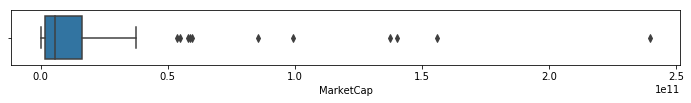

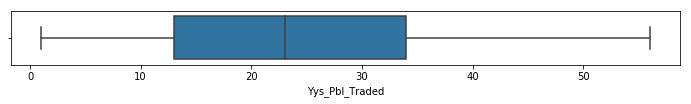

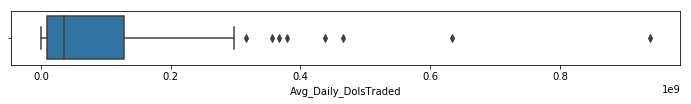

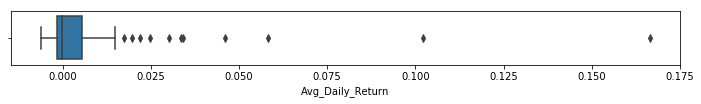

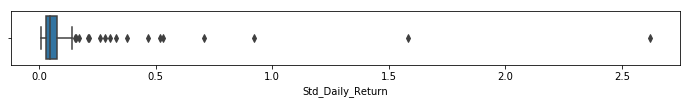

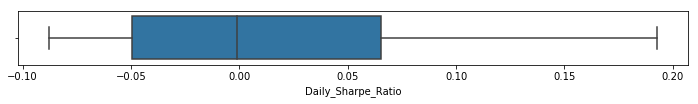

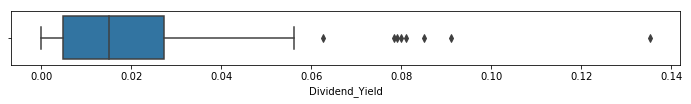

In [14]:
# Visualizing the columns data
for i, col in enumerate(mydata.columns[1:]):
    plt.figure(figsize=(12,1))
    sns.boxplot(x=col, data=mydata)
plt.show()

In [15]:
# Builds Quartiles value objects
Q1 = mydata.quantile(0.25)
Q3 = mydata.quantile(0.75)
IQR = Q3 - Q1

# Reasonable Inner Fences/Borders Outliers counts
((mydata.loc[:, 'MarketCap':'Dividend_Yield'] < (Q1 - 1.5 * IQR)) | 
(mydata.loc[:, 'MarketCap':'Dividend_Yield'] > (Q3 + 1.5 * IQR))).sum().to_frame('Outliers-Count')

,Outliers-Count
MarketCap,11
Yys_Pbl_Traded,0
Avg_Daily_DolsTraded,8
Avg_Daily_Return,11
Std_Daily_Return,17
Daily_Sharpe_Ratio,0
Dividend_Yield,8


In [16]:
# Extrem Outter Fences/Borders outliers counts
((mydata.loc[:, 'MarketCap':'Dividend_Yield'] < (Q1 - 3 * IQR)) | 
(mydata.loc[:, 'MarketCap':'Dividend_Yield'] > (Q3 + 3 * IQR))).sum().to_frame('Outliers-Count')

,Outliers-Count
MarketCap,6
Yys_Pbl_Traded,0
Avg_Daily_DolsTraded,2
Avg_Daily_Return,7
Std_Daily_Return,12
Daily_Sharpe_Ratio,0
Dividend_Yield,1


In [17]:
mydata.head(1)

,Symbol,MarketCap,Yys_Pbl_Traded,Avg_Daily_DolsTraded,Avg_Daily_Return,Std_Daily_Return,Daily_Sharpe_Ratio,Dividend_Yield
0,A,2.172296e+10,19.0,108476601.0,0.001548,0.010437,0.148329,0.006698


In [18]:
# Resets Index to value ('Symbol')
mydata = mydata.set_index('Symbol')

# Excluding outliers withing 3 Standard Deviations
mydata = mydata[mydata.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]
mydata.shape

(92, 7)

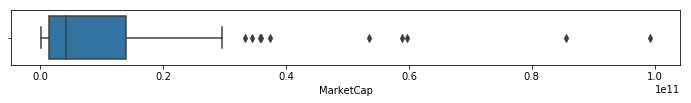

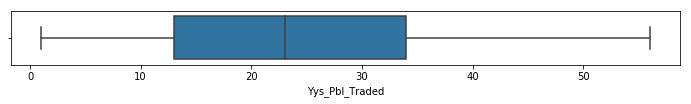

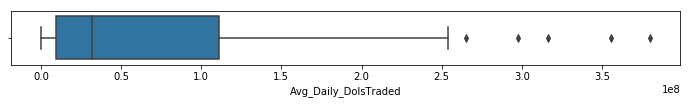

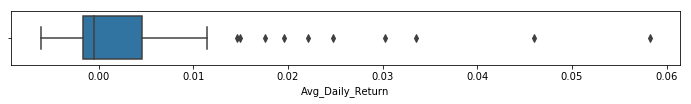

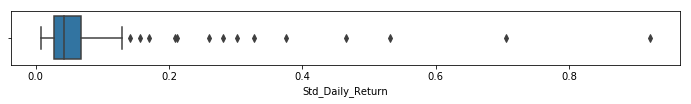

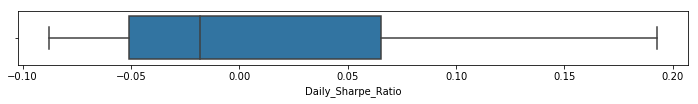

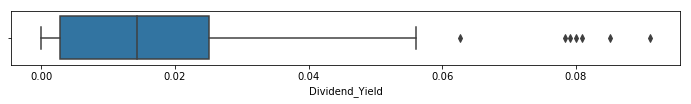

In [19]:
# Visualizing the columns data after treatment of outliers
for i, col in enumerate(mydata.columns[:]):
    plt.figure(figsize=(12,1))
    sns.boxplot(x=col, data=mydata)
plt.show()

### Scaling Data for Model

In [20]:
# Turns data into a matrix box
data = mydata.as_matrix(columns=[ 'MarketCap', 'Yys_Publ_Trded','Avg_Daily_DolsTraded',
       'Avg_Daily_Return', 'Std_Daily_Return', 'Daily_Sharpe_Ratio',
       'Dividend_Yield'])

x_cols = data

# scales data
scaled_cols = preprocessing.scale(x_cols)
print('mean:',round(scaled_cols.mean()))
print('std:',scaled_cols.std())

mean: 0.0
std: 1.0


C:\Users\Alfredo\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [21]:
#splits data
clust_train, clust_test = train_test_split(scaled_cols, test_size=.3, random_state=123)

print(clust_train.shape)
print(clust_test.shape)

(64, 6)
(28, 6)


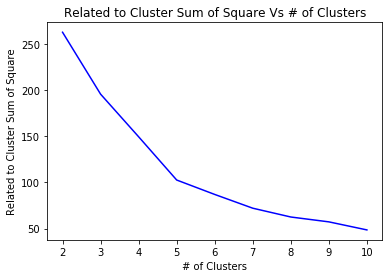

In [22]:
# Searching for elbow(optimal number of clusters)
# Average distance value to centroids
K_range = range(2,11)
y =[]

for k in K_range:
    k_means = KMeans(n_clusters= k, random_state = 1, init = 'k-means++')
    k_means.fit(clust_train)
    labels=k_means.labels_
    y.append(k_means.inertia_)

plt.plot(K_range, y, color='blue')
plt.xlabel('# of Clusters')
plt.ylabel('Related to Cluster Sum of Square')
plt.title('Related to Cluster Sum of Square Vs # of Clusters')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.407461586407


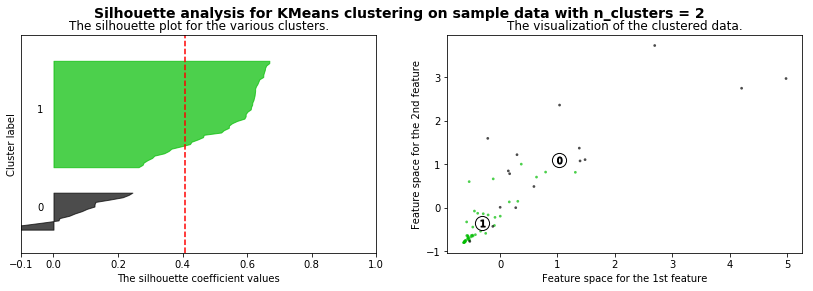

For n_clusters = 3 The average silhouette_score is : 0.393193167898


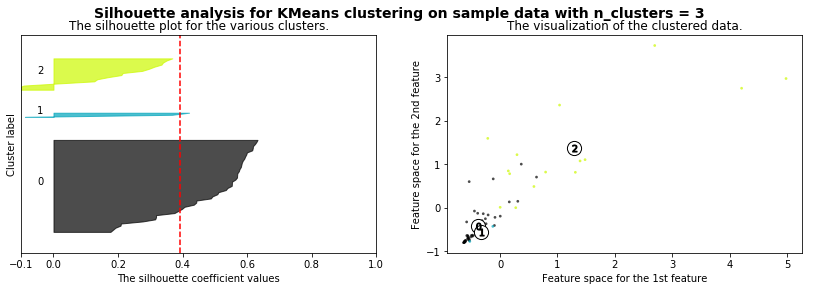

For n_clusters = 4 The average silhouette_score is : 0.370508210404


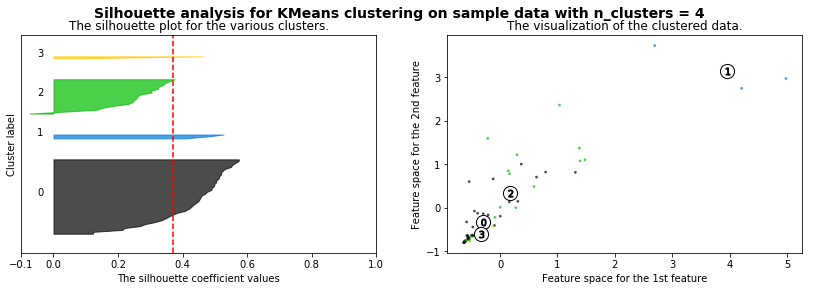

For n_clusters = 5 The average silhouette_score is : 0.415223390883


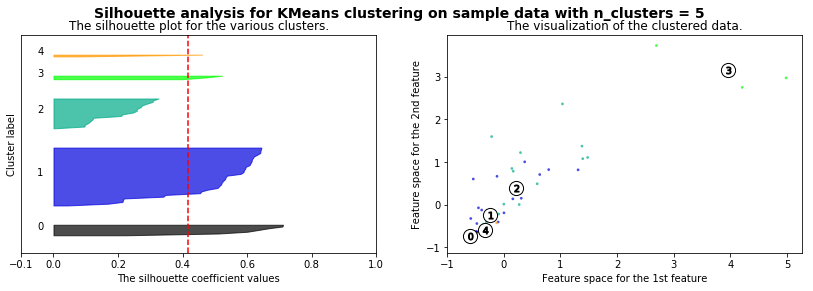

For n_clusters = 6 The average silhouette_score is : 0.391604625076


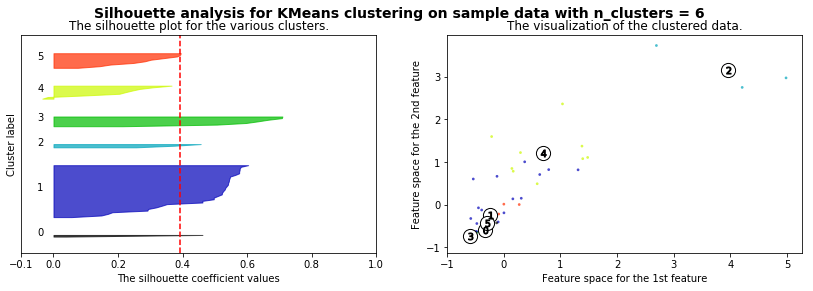

In [23]:
range_n_clusters = [2, 3, 4, 5, 6]
X=clust_train

for n_clusters in range_n_clusters:
    
# SETTING THE PLOTS ONE ROW AND TWO COLUMNS FOR EACH SAMPLE, ALSO SETS THE SIZE OF EACH BOX
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(14, 4)
    

# THE FIRST COLUMN BOX FOR EACH ROW(AX1) REPRESENTS THE GRAPH OF THE SILHOUETE COEFFICIENTS
   # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
    
# IT FITS THE DATA AND PREDICT THE CENTROIDS/CLUSTERS 
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(clust_train)
    
# IT CALCULATES THE AVERAGE SCORES FOR EACH # OF CLUSTERS, THE CLOSER TO ONE THE BETTER FIT   
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(clust_train, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    
     # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(clust_train, cluster_labels)
    
    
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

In [24]:
X = clust_train
Kmean = KMeans(n_clusters=5)
Kmean.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [25]:
pca_2 = PCA(2)

plot_columns = pca_2.fit_transform(clust_train)
len(plot_columns)

64

In [26]:
# Cluster/Target value given to each Individual point in dataset
Kmean.labels_

array([3, 0, 4, 1, 3, 0, 1, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 0, 3, 3, 3, 3, 1,
       1, 3, 4, 1, 3, 3, 1, 1, 1, 0, 1, 3, 3, 3, 3, 3, 0, 3, 4, 1, 1, 0, 2,
       3, 1, 1, 3, 3, 3, 3, 3, 1, 2, 3, 3, 3, 1, 3, 3, 3, 0])

In [27]:
# Centroids cordinates
Kmean.cluster_centers_

array([[-0.5900059 , -0.73461112, -0.46655695, -0.41684031, -0.68905545,
         2.40074803],
       [ 0.21294916,  0.40127032,  0.42146967,  0.17666502,  1.18152174,
        -0.28600736],
       [-0.3283886 , -0.59961628,  4.0837936 ,  4.39334312,  0.84885509,
         0.05520021],
       [-0.25035884, -0.25031626, -0.48035517, -0.38064329, -0.65381395,
        -0.29472215],
       [ 3.9632548 ,  3.14869757,  0.32417689, -0.0271612 ,  1.71566   ,
        -0.13164776]])

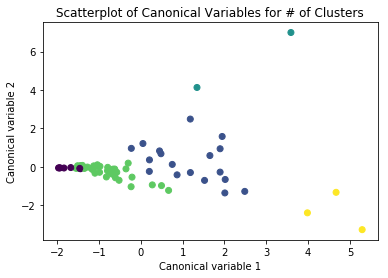

In [28]:
# plot columns
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=Kmean.labels_,)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for # of Clusters')
plt.show()

### Finding Clusters Values and Arrays

In [29]:
# Identifying Potential Outlier in cluster
def ClusterIndicesNumpy(clustNum, labels_array): #numpy 
    return np.where(labels_array == clustNum)[0]

In [30]:
print('1 array: \n', ClusterIndicesNumpy(0, Kmean.labels_), '\n')
print('2 array: \n', ClusterIndicesNumpy(1, Kmean.labels_), '\n')
print('3 array: \n', ClusterIndicesNumpy(2, Kmean.labels_), '\n')
print('4 array: \n', ClusterIndicesNumpy(3, Kmean.labels_), '\n')
print('5 array: \n', ClusterIndicesNumpy(4, Kmean.labels_), '\n')

1 array: 
 [ 1  5 17 32 39 44 63] 

2 array: 
 [ 3  6  9 12 14 22 23 26 29 30 31 33 42 43 47 48 54 59] 

3 array: 
 [45 55] 

4 array: 
 [ 0  4  7  8 10 11 13 15 16 18 19 20 21 24 27 28 34 35 36 37 38 40 46 49 50
 51 52 53 56 57 58 60 61 62] 

5 array: 
 [ 2 25 41] 

